# Simulating Circuits with the Restless Simulator

The restless simulator can be used to simulate restless circuit execution of single-qubit/qutrit
circuits, where qubit/qutrit reset is skipped. This means that the input-state of a circuit may not
be the ground state $\ket{0}$. In this notebook you will learn how to create a restless simulator
instance, how to simulate circuits with restless circuit execution, and how to post-process the
restless data to recover the standard circuit-execution measurements.


## Running qubit circuits with restless


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit

from restless_simulator.simulator import QutritRestlessSimulator

You can construct a restless simulator from the `QutritRestlessSimulator` class. To demonstrate how
the simulator works, we will create a series of single-qubit circuits with an initial $RX(\pi/2)$
gate and an increasing number of identical $RX(\pi/3)$ gates. We do not need to add measurements as
these are implicitly applied by the simulator. We will start with qubit gates. The simulator treats
all qubits as qutrits and will automatically embed qubit-gates in SU(3) such that the $|2\rangle$
population never changes.


In [8]:
simulator = QutritRestlessSimulator()

Here we create 10 circuits with increasing number of $RX(\pi/3)$ gates.


In [9]:
circuits = []
N_CIRCUITS = 10
for n in range(N_CIRCUITS):
    nth_circ = QuantumCircuit(1)
    # Each circuit starts with an RX(pi/2) gate
    nth_circ.rx(np.pi / 2, 0)
    for _ in range(n):
        nth_circ.rx(np.pi / 3, 0)
    circuits.append(nth_circ)

In [10]:
circuits[-1].draw()

┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐»
q: ┤ Rx(π/2) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├»
   └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«   ┌─────────┐┌─────────┐┌─────────┐┌─────────┐
«q: ┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├
«   └─────────┘└─────────┘└─────────┘└─────────┘

We execute our circuits with the simulator by calling `run()`. The default configuration of the
simulator will execute circuits with restless and without post-measurement error. This means that
the post-measurement state is the collapsed measurement state. The simulator defaults to qubit
discrimination, which labels the $|1\rangle$ and $|2\rangle$ states as the state-label "1". The
returned `job` object contains all results for our circuit execution, but the measurement outcomes
need to be post-processed to reconstruct the standard measurements (i.e., as if we had not used
restless circuit execution).


In [11]:
job = simulator.run(circuits)

## Restless post-processing

The `utils` submodule of the restless simulator package contains functions to run restless
post-processing. They do the following:

1.  `extract_memory`: Extracts a 2D array of single-shot measurement outcomes (i.e., memory) from a
    job instance. If we used restless circuit execution, these outcomes would be the restless memory
    outcomes. Later on we will see how to emulate standard circuit execution with the simulator.
2.  `restless_memory_to_memory`: Converts restless memory outcomes to standard memory outcomes by
    1.  reshaping the memory array into a time-ordered sequence of outcomes,
    2.  taking the exclusive OR between successive measurement outcomes (as required by restless
        circuit execution),
    3.  and then reshaping the results to match the expected shape of a memory array (i.e., circuits
        x shots).
3.  `memory_to_probabilities`: Reconstructs the probability to measure an outcome based on the
    number of occurrences of said outcome in a memory array.

These three functions can be used in sequence to obtain the probability to measure $|0\rangle$ for
each circuit, even if restless circuit execution was used.


In [12]:
from restless_simulator.utils import (
    extract_memory,
    restless_memory_to_memory,
    memory_to_probabilities,
)


Here we reconstruct the standard measurement outcomes from the restless measurement outcomes using
the above functions.


In [13]:
restless_outcomes = extract_memory(job)
reconstructed_outcomes = restless_memory_to_memory(restless_outcomes)
reconstructed_probs = memory_to_probabilities(reconstructed_outcomes)

As a comparison, we also compute the outcome probabilities without restless post-processing step,
i.e., `restless_memory_to_memory`. These probabilities should give us very little insight into the
behaviour of the circuits as we have not corrected for the lack of qubit/qutrit reset.


In [14]:
naive_probs = memory_to_probabilities(restless_outcomes)

As our circuits contain repeated applications of the $RX(\pi/3)$ gate, we know how to compute the
ideal probabilities analytically. If we represent the probability to measure `"0"` $P_0[n]$ as a
function of the number of $RX(\pi/3)$ gates $n$, we get the following cosine.

$$
P_0[n] = \frac{1}{2}\cos{\left(\frac{\pi}{3}n + \frac{\pi}{2}\right)} + \frac{1}{2}
$$

The additional phase in the cosine accounts for the initial $RX(\pi/2)$ gate in the circuits.


In [15]:
expected_probs = (
    0.5 * np.cos(np.pi / 3 * np.arange(N_CIRCUITS, step=0.1) + np.pi / 2) + 0.5
)

Now we plot the
1. reconstructed probabilities,
2. naive probabilities (i.e., without restless post-processing),
3. and the cosine function of the ideal probabilities, interpolated to real $n$ values.


Text(0, 0.5, 'Probability to Measure $|0\\rangle$')

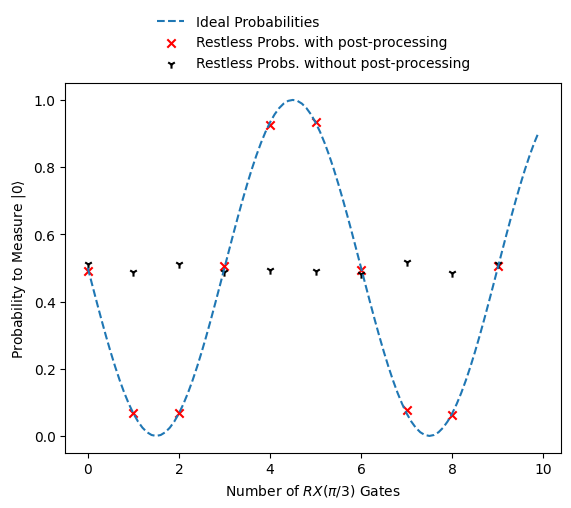

In [19]:
plt.plot(
    np.arange(N_CIRCUITS, step=0.1),
    expected_probs,
    label="Ideal Probabilities",
    linestyle="--",
)
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(restless_memory_to_memory(extract_memory(job))),
    label="Restless Probs. with post-processing",
    marker="x",
    color="r",
)
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(extract_memory(job)),
    label="Restless Probs. without post-processing",
    marker="1",
    color="k",
)

plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), frameon=False)
plt.xlabel("Number of $RX(\\pi/3)$ Gates")
plt.ylabel("Probability to Measure $|0\\rangle$")

As you can see, the expected probabilities are accurately recovered by applying restless
post-processing on the restless measurements. Without this post-processing step, the measurement
outcomes are all at roughly $0.5$, which gives us very little insight into the circuits' behaviour.
